In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from pathlib import Path
from wordcloud import WordCloud
pd.set_option('display.max_columns', None)

In [106]:
def load_raw_data(filename):
    BASE_DIR = Path.cwd().parents[0]
    return pd.read_csv(BASE_DIR / "data" / "raw" / filename)


In [107]:
df = load_raw_data(r'PublicAssistanceGrantAwardActivities.csv')

In [108]:
df.shape

(948686, 23)

### **Negative Values in federalShareObligated**

During exploratory data analysis, a small number of observations in the federalShareObligated column were found to have negative values. At first glance, this may appear counterintuitive, as the variable represents FEMA’s obligated share of disaster recovery costs. However, these negative values are not data errors and do not indicate negative disaster losses.

In the FEMA Public Assistance program, funding is often obligated based on initial cost estimates and may be revised over time as projects undergo further review, scope clarification, audits, or closeout. When FEMA reduces or reverses a previously obligated amount—due to overestimation, ineligible expenses, or administrative reconciliation—the adjustment is recorded as a negative obligated value. These records therefore represent de-obligations or accounting corrections, rather than actual recovery expenditures.

From an analytical standpoint, the objective of this project is to model disaster cost severity and tail risk, where the focus is on the magnitude of financial losses associated with recovery activities. Negative obligated amounts do not reflect disaster impact or recovery cost severity; instead, they encode post-decision administrative adjustments that occur after funding has already been evaluated and approved.

For this reason, negative values of federalShareObligated were excluded from subsequent analysis and modeling. Restricting the dataset to non-negative obligated amounts ensures that the target variable represents meaningful, realized recovery costs and preserves the interpretability of quantile-based models. Given that negative values constitute only a very small fraction of the dataset, their removal does not materially affect the overall distribution but significantly improves conceptual clarity and modeling validity.

In [111]:
df_clean = df.loc[df.federalShareObligated>0]

In [112]:
# Preview the data
df_clean.head(5)

,region,disasterNumber,sriaDisaster,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,pnpStatus,damageCategoryCode,federalShareObligated,dateObligated,pwNumber,projectTitle,versionNumber,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,9,1397,0,EARTHQUAKE,DR,Earthquake,2001-12-05T00:00:00.000Z,GU,Guam,Statewide,000-U6K9Y-00,GUAM WATERWORKS AUTHORITY,0.0,F - Public Utilities,121.50,2002-02-01T00:00:00.000Z,37,PUMP STATION REPAIR - HAIRLINE CRACKS,0.0,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
1,4,1381,0,TROPICAL STORM ALLISON,DR,Severe Storm,2001-06-17T00:00:00.000Z,FL,Florida,Washington,133-99133-00,WASHINGTON COUNTY,0.0,C - Roads and Bridges,3116.84,2001-10-03T00:00:00.000Z,210,ROADS AND BRIDGES,0.0,E,O,C,553d4c29-85ef-4002-ad7f-0b10c0b3da19
2,6,1709,0,"SEVERE STORMS, TORNADOES, AND FLOODING",DR,Severe Storm,2007-06-29T00:00:00.000Z,TX,Texas,Henderson,213-99213-00,HENDERSON (COUNTY),0.0,C - Roads and Bridges,7211.69,2007-11-09T00:00:00.000Z,2594,ROADS AND BRIDGES,0.0,E,O,C,743771d1-7292-4009-afc7-a8258ebc4414
3,4,1549,0,HURRICANE IVAN,DR,Hurricane,2004-09-15T00:00:00.000Z,AL,Alabama,Baldwin,003-57144-00,ORANGE BEACH,0.0,A - Debris Removal,129387.21,2005-01-29T00:00:00.000Z,1509,DEBRIS REMOVAL,0.0,E,O,C,4c86e4b3-3e25-4b89-904a-26048d4181c1
4,5,1370,0,"SEVERE WINTER STORMS, FLOODING, AND TORNADOES",DR,Flood,2001-05-16T00:00:00.000Z,MN,Minnesota,Houston,055-33866-00,LA CRESCENT,0.0,A - Debris Removal,11512.50,2001-09-22T00:00:00.000Z,1418,DEBRIS REMOVAL,0.0,E,O,C,158efd8c-5c67-418b-8951-6e3ca9be537e


In [113]:
# Summary of dataset
df_clean.describe()

,region,disasterNumber,sriaDisaster,pnpStatus,federalShareObligated,pwNumber,versionNumber
count,786608.000000,786608.000000,786608.000000,777320.000000,7.866080e+05,786608.000000,777320.000000
mean,4.818339,2138.751678,0.063750,0.064336,1.269825e+05,2074.382504,0.324277
std,2.221364,974.280428,0.244307,0.245351,4.120445e+06,3226.321412,0.910622
min,1.000000,1239.000000,0.000000,0.000000,1.000000e-02,1.000000,0.000000
25%,3.000000,1574.000000,0.000000,0.000000,2.358380e+03,233.000000,0.000000
50%,5.000000,1738.000000,0.000000,0.000000,7.210565e+03,757.000000,0.000000
75%,6.000000,1973.000000,0.000000,0.000000,2.588261e+04,2352.000000,0.000000
max,10.000000,5538.000000,1.000000,1.000000,1.399420e+09,83562.000000,69.000000


In [114]:
df_clean.describe(include='O')

,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,damageCategoryCode,dateObligated,projectTitle,eligibilityStatus,fundingStatus,paCloseoutStatus,id
count,786608,786608,786608,786608,786608,786608,777317,786608,786608,786608,786608,781833,786608,786608,786608,786608
unique,1237,3,25,1616,57,59,2327,57961,62544,17,7422,380399,5,2,2,786608
top,SEVERE STORMS AND FLOODING,DR,Severe Storm,2005-08-29T00:00:00.000Z,FL,Florida,Statewide,000-UNELM-00,WV DIVISION OF HIGHWAYS,C - Roads and Bridges,2007-06-19T00:00:00.000Z,ROADS AND BRIDGES,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
freq,105580,750408,340484,58420,76534,76534,135958,7926,7426,245106,5363,58240,785071,785078,623779,1


In [115]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786608 entries, 0 to 948684
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   region                 786608 non-null  int64  
 1   disasterNumber         786608 non-null  int64  
 2   sriaDisaster           786608 non-null  int64  
 3   declarationTitle       786608 non-null  object 
 4   disasterType           786608 non-null  object 
 5   incidentType           786608 non-null  object 
 6   declarationDate        786608 non-null  object 
 7   stateAbbreviation      786608 non-null  object 
 8   state                  786608 non-null  object 
 9   county                 777317 non-null  object 
 10  applicantId            786608 non-null  object 
 11  applicantName          786608 non-null  object 
 12  pnpStatus              777320 non-null  float64
 13  damageCategoryCode     786608 non-null  object 
 14  federalShareObligated  786608 non-null  f

In [116]:
# Checking for duplicated instances
df_clean.duplicated(keep=False).sum()

np.int64(0)

In [117]:
# Checking for null values
null_df = (
    df_clean.isna()
      .sum()
      .to_frame(name="null_values")
      .reset_index()
      .rename(columns={"index": "feature_name"})
      .sort_values(by="null_values", ascending=False)
)

null_df

,feature_name,null_values
9,county,9291
12,pnpStatus,9288
18,versionNumber,9288
17,projectTitle,4775
0,region,0
1,disasterNumber,0
2,sriaDisaster,0
6,declarationDate,0
5,incidentType,0
4,disasterType,0


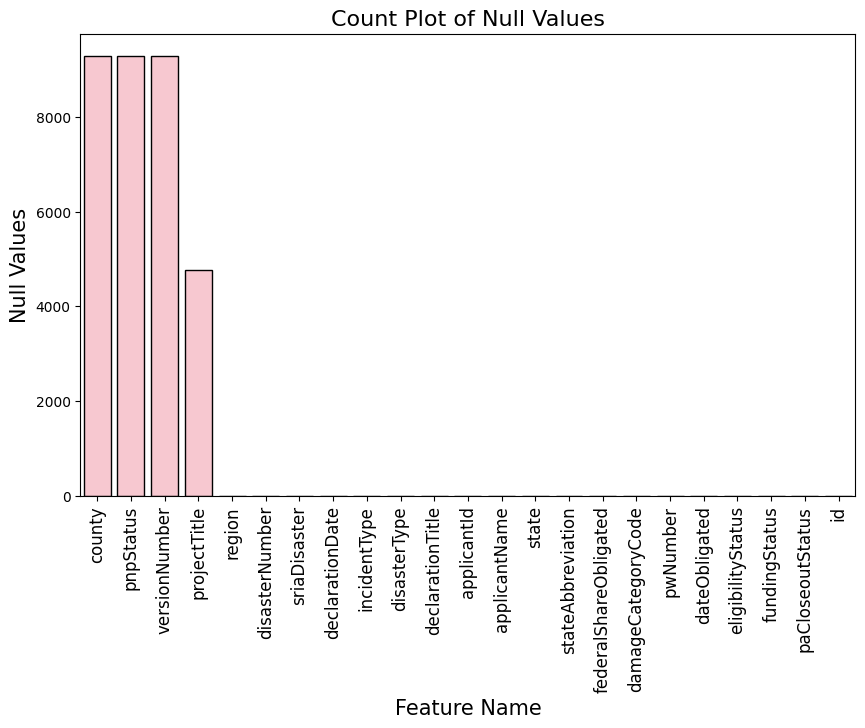

In [ ]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=null_df,
    x='feature_name',
    y='null_values',
    edgecolor='black',
    color='pink'
)
ax.set_ylabel("Null Values", fontsize=15)
ax.set_xlabel("Feature Name", fontsize=15)
ax.set_title("Count Plot of Null Values", fontsize=16)
ax.tick_params(axis='x', labelrotation=90, labelsize=12)

plt.show()

In [119]:
df_clean = df_clean.assign(
    dateObligated = pd.to_datetime(df_clean.dateObligated.str.split("T").str[0]),
    declarationDate = pd.to_datetime(df_clean.declarationDate.str.split("T").str[0])
)

In [120]:
num_cols = df_clean.select_dtypes(include=[int, float]).columns.to_list()
cat_cols = df_clean.select_dtypes(include='O').columns.to_list()

print(f"There are {len(num_cols)} Numerical columns: {num_cols}")
print(f"There are {len(cat_cols)} Categorical columns: {cat_cols}")

There are 7 Numerical columns: ['region', 'disasterNumber', 'sriaDisaster', 'pnpStatus', 'federalShareObligated', 'pwNumber', 'versionNumber']
There are 14 Categorical columns: ['declarationTitle', 'disasterType', 'incidentType', 'stateAbbreviation', 'state', 'county', 'applicantId', 'applicantName', 'damageCategoryCode', 'projectTitle', 'eligibilityStatus', 'fundingStatus', 'paCloseoutStatus', 'id']


# Univariate Analysis

**A. Numerical columns**

**region**: Identifies the FEMA administrative region responsible for overseeing the disaster response and recovery activities. FEMA divides the country into regions to manage operations more efficiently, and this field indicates which regional office handled coordination, approvals, and monitoring of projects and funding for a given disaster. It is useful for regional-level analysis, workload comparison, and understanding geographic variations in disaster management practices.

**disasterNumber**: A unique numeric identifier assigned by FEMA to each officially declared disaster. This number acts as the primary key linking all related records, including applications, project worksheets, funding obligations, and revisions. It enables tracking a disaster across time and datasets and is essential for aggregating impacts, costs, and recovery outcomes at the disaster-event level.

**sriaDisaster**: Indicates whether the disaster is covered under the Special Risk Insurance Act (SRIA). This flag affects insurance-related considerations and eligibility for certain types of federal assistance, especially in cases involving insurable properties. It helps distinguish disasters with additional regulatory or insurance constraints from standard disaster declarations.

**pnpStatus**: Specifies whether the applicant is a Public entity or a Private Non-Profit (PNP) organization. This classification directly influences eligibility criteria, documentation requirements, and cost-sharing rules under FEMA’s Public Assistance program. It is important for analyzing differences in funding patterns, approval timelines, and recovery outcomes between public agencies and non-profit organizations.

**federalShareObligated**: Represents the actual amount of federal funding that has been formally obligated for a specific project or work item. This is a key financial variable, reflecting confirmed government spending rather than estimated costs. It is critical for expenditure analysis, budget monitoring, and assessing the financial impact of disasters across regions, disaster types, or applicant categories.

**pwNumber**: Stands for Project Worksheet Number and uniquely identifies individual damage, repair, or recovery projects within a disaster. Each project worksheet documents the scope of work, estimated costs, approvals, and funding decisions. This column allows granular analysis at the project level, such as cost distribution, project complexity, and approval frequency within a single disaster.

**versionNumber**: Indicates the revision number of a project worksheet, capturing how many times the project details, scope, or cost estimates have been updated after initial submission. Higher version numbers often reflect project changes, reassessments, or corrections over time, making this field valuable for audit trails, change tracking, and understanding how recovery projects evolve during the disaster response lifecycle.

In [121]:
df_clean[num_cols]

,region,disasterNumber,sriaDisaster,pnpStatus,federalShareObligated,pwNumber,versionNumber
0,9,1397,0,0.0,121.50,37,0.0
1,4,1381,0,0.0,3116.84,210,0.0
2,6,1709,0,0.0,7211.69,2594,0.0
3,4,1549,0,0.0,129387.21,1509,0.0
4,5,1370,0,0.0,11512.50,1418,0.0
...,...,...,...,...,...,...,...
948675,2,4348,1,0.0,19595.51,124,2.0
948676,8,4440,1,0.0,6010.25,1129,1.0
948677,2,4339,1,1.0,5569.66,522,3.0
948683,3,4512,1,1.0,20663.42,134,1.0


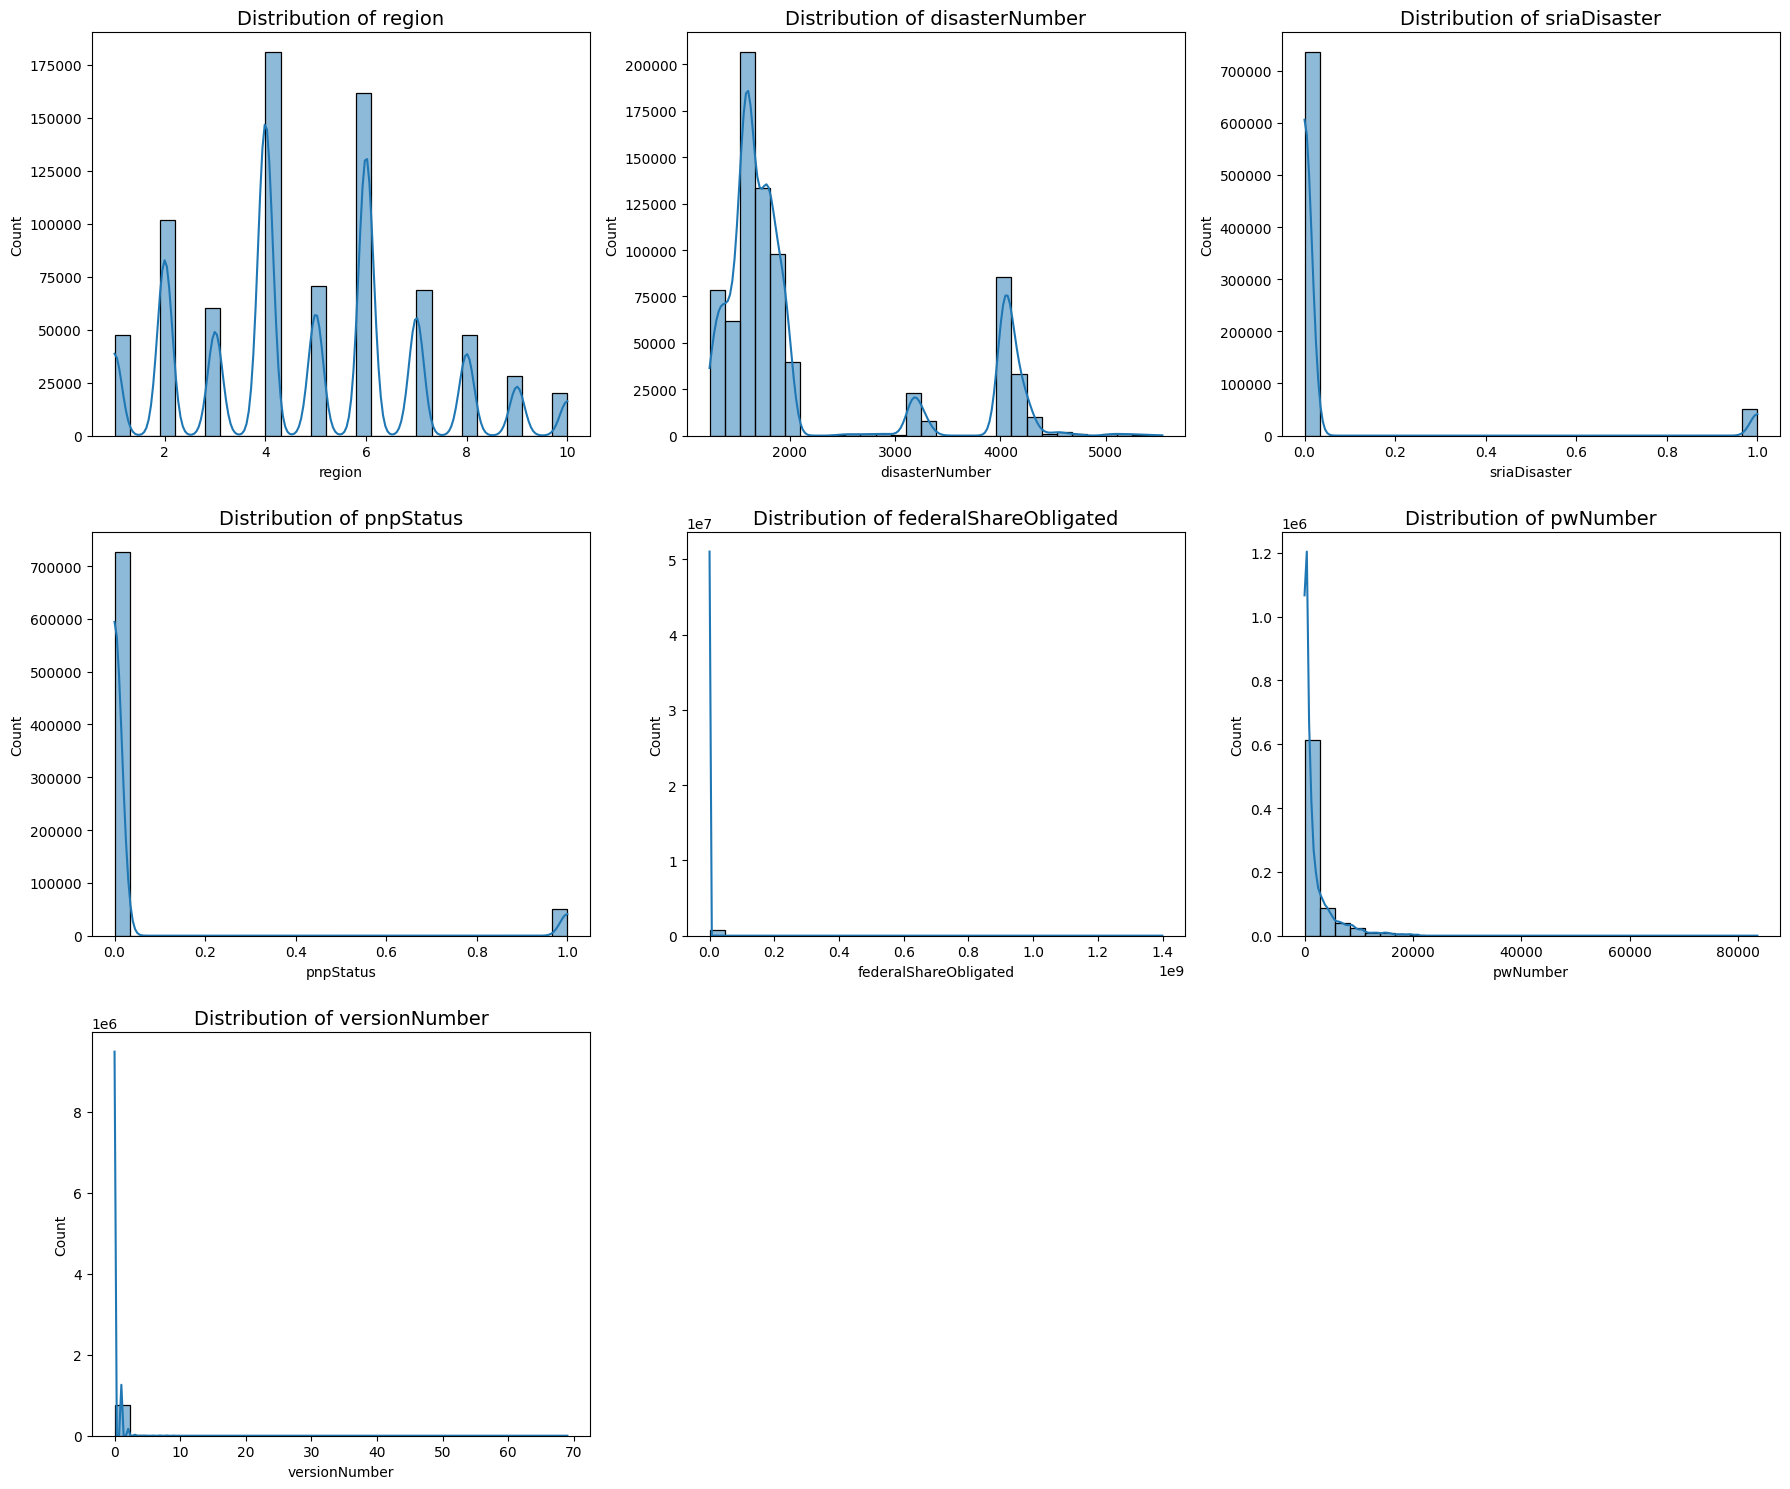

In [122]:
n_cols = 3  # number of plots per row
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()  # makes indexing easy

for idx, col in enumerate(num_cols):
    sns.histplot(
        data=df_clean,
        x=col,
        kde=True,
        ax=axes[idx],
        bins=30
    )
    
    axes[idx].set_title(f"Distribution of {col}", fontsize=14)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")

# Remove empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

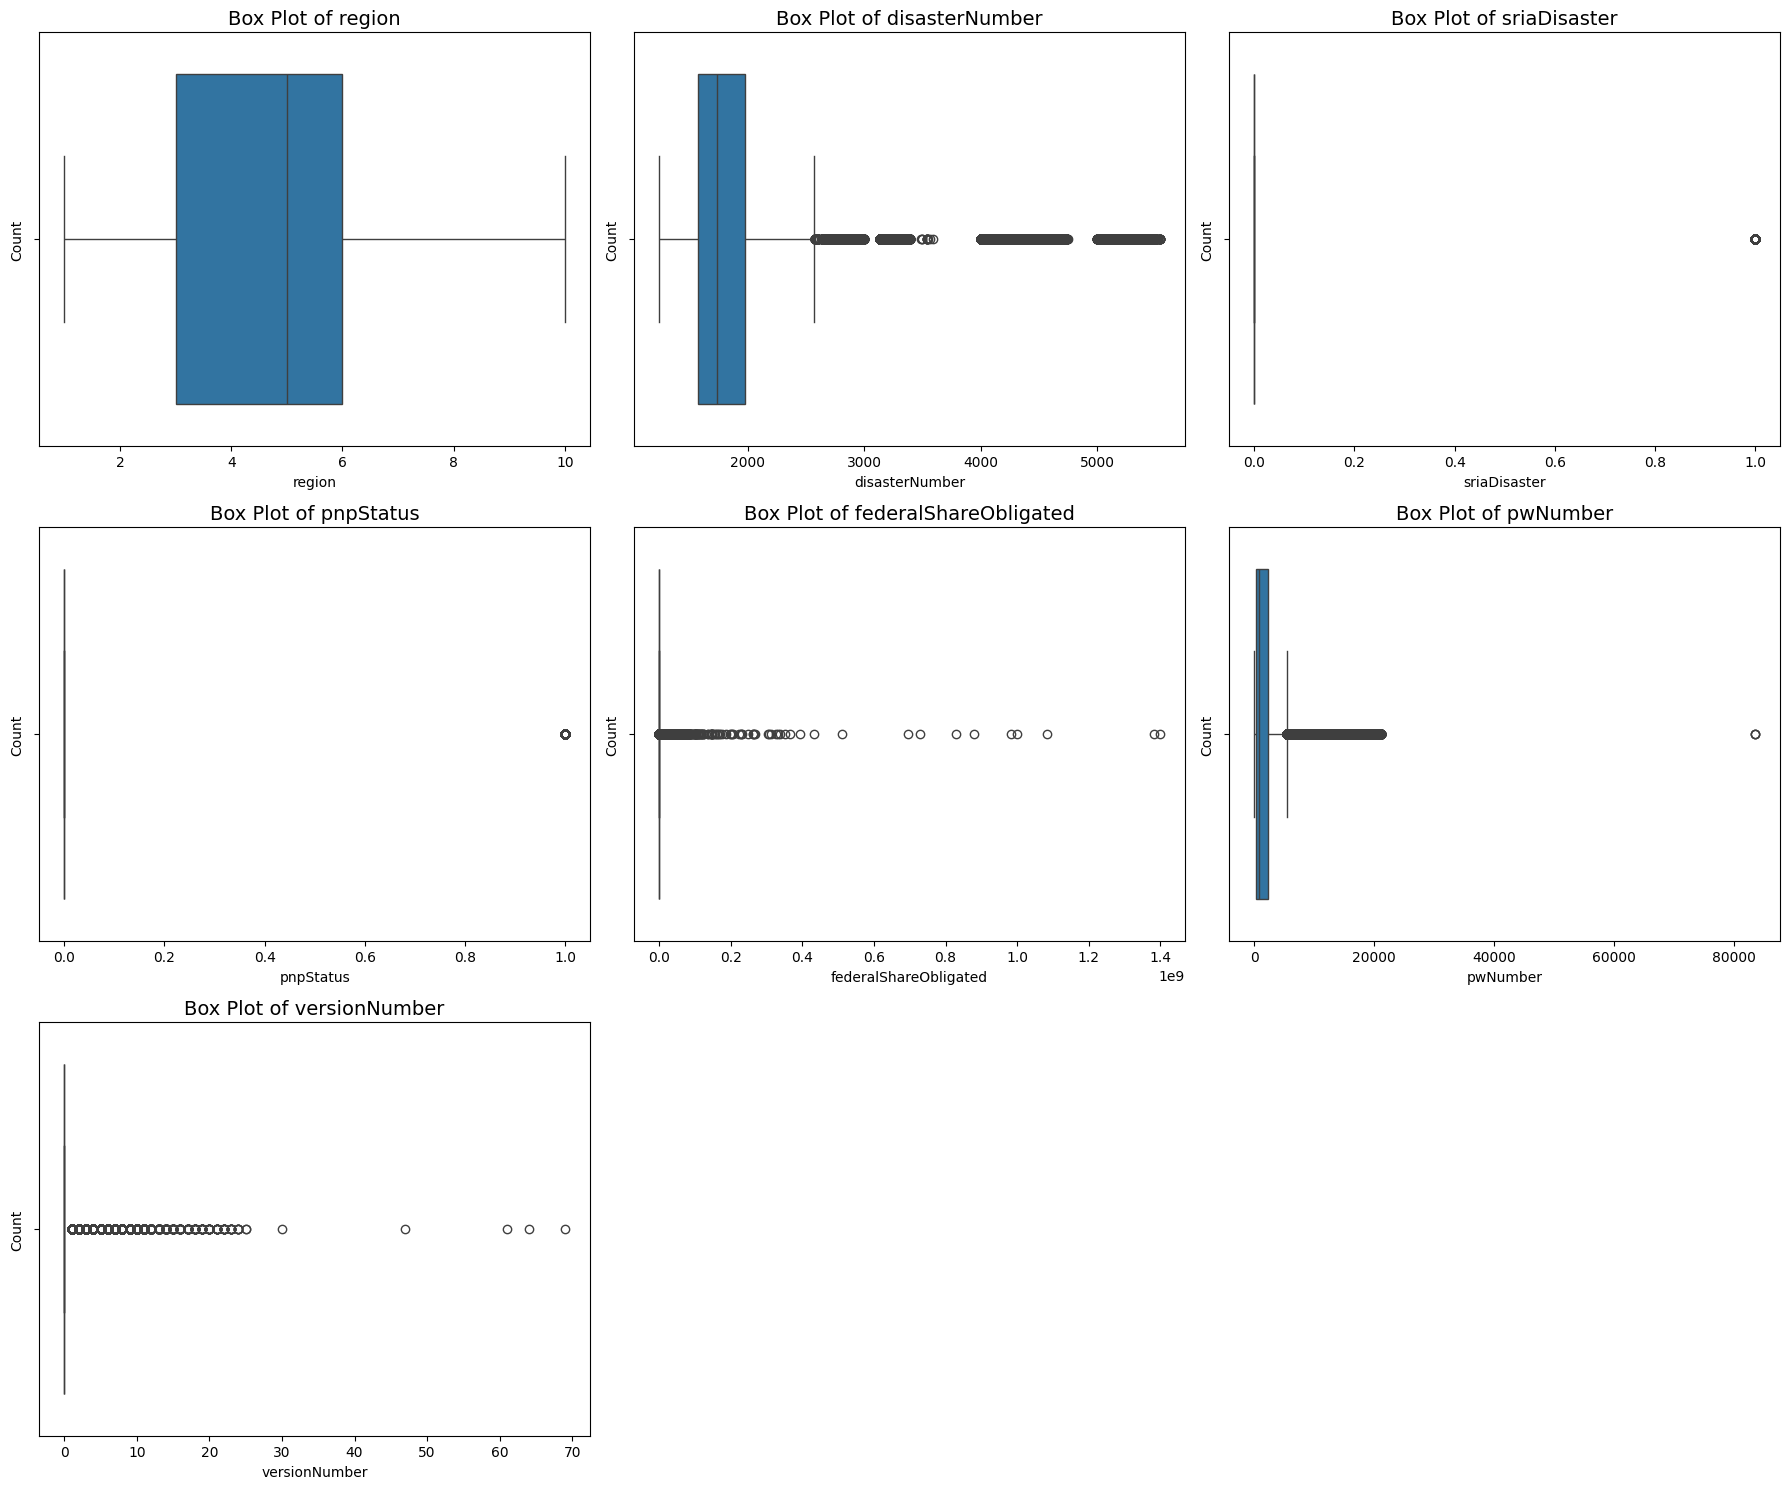

In [123]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()  # makes indexing easy

for idx, col in enumerate(num_cols):
    sns.boxplot(
        data=df_clean,
        x=col,
        ax=axes[idx]
    )
    
    axes[idx].set_title(f"Box Plot of {col}", fontsize=14)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")

# Remove empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


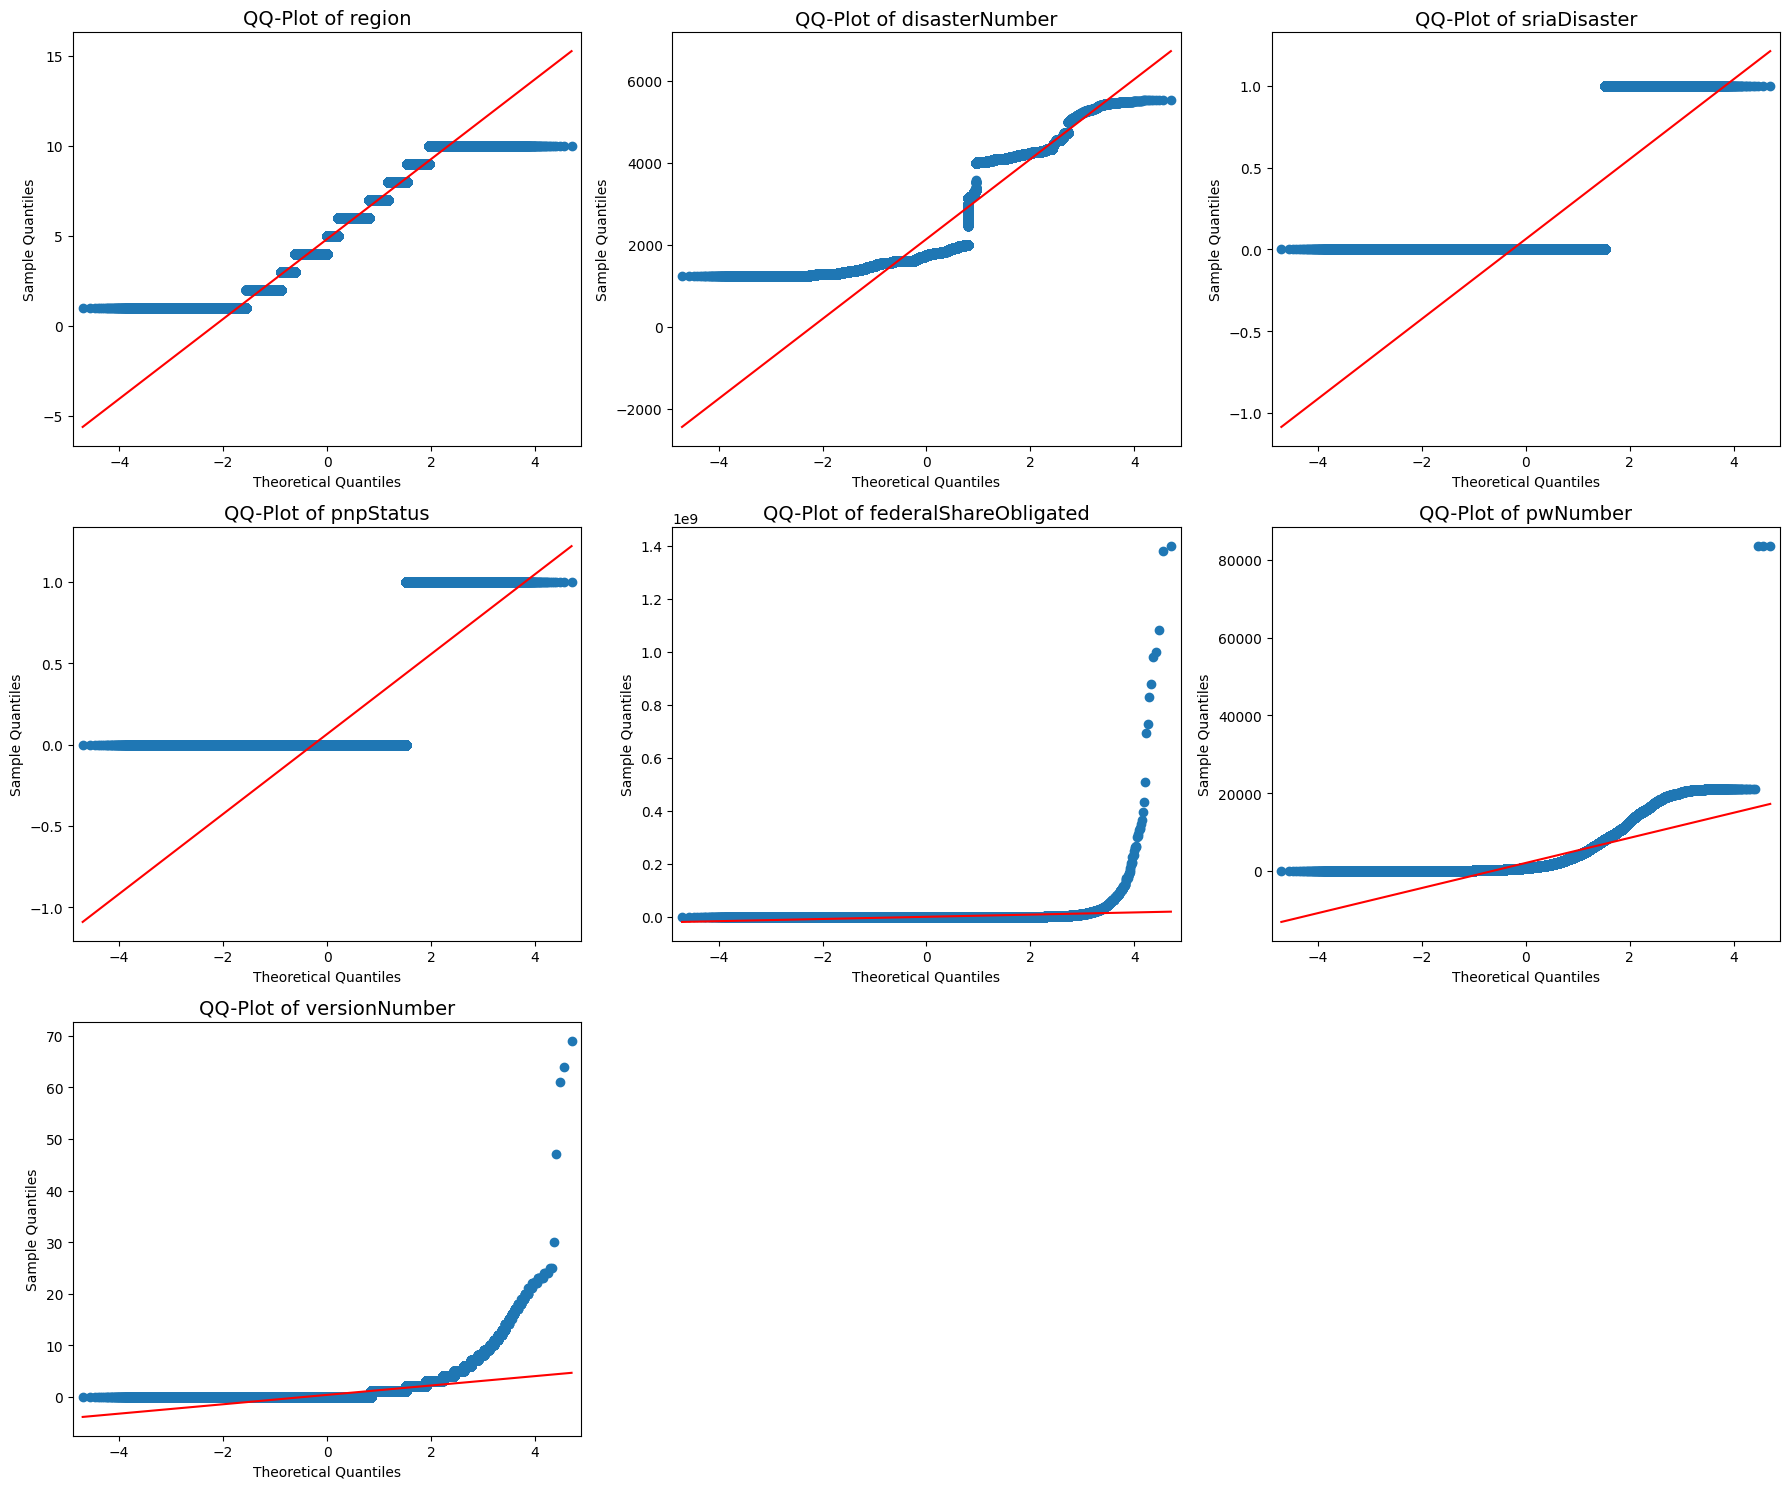

In [125]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(num_cols):
    sm.qqplot(
        df_clean[col].dropna(),
        line='s',
        ax=axes[idx]
    )

    axes[idx].set_title(f"QQ-Plot of {col}", fontsize=14)
    axes[idx].set_xlabel("Theoretical Quantiles")
    axes[idx].set_ylabel("Sample Quantiles")

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [126]:
# Calculating skewness and kurtosis of each numerical feature
stats_df = (
    df_clean[num_cols]
    .agg(['skew', 'kurt'])
    .T
    .reset_index()
    .rename(columns={'index': 'feature'})
)

In [127]:
stats_df

,feature,skew,kurt
0,region,0.227625,-0.548824
1,disasterNumber,1.409376,0.347413
2,sriaDisaster,3.571344,10.754522
3,pnpStatus,3.551352,10.612128
4,federalShareObligated,207.951906,55800.643048
5,pwNumber,2.757261,9.805258
6,versionNumber,7.479452,175.232664


**B. Categorical columns**

**declarationTitle**: Describes the official title of the disaster declaration as issued by FEMA, typically summarizing the nature, location, or scope of the event. This field provides contextual information about the disaster and is useful for grouping similar events, validating disaster metadata, and improving interpretability when presenting or reporting results.

**disasterType**: Indicates the type of FEMA disaster declaration (for example, major disaster, emergency, or fire management assistance). This classification determines the level of federal involvement, available assistance programs, and overall funding mechanisms, making it important for policy-level analysis and comparison across disaster responses.

**incidentType**: Specifies the underlying hazard or cause of the disaster, such as flood, hurricane, wildfire, earthquake, or severe storm. This column is critical for hazard-based analysis, allowing comparison of impacts, costs, and recovery patterns across different types of incidents.

**stateAbbreviation**: Contains the standard two-letter abbreviation of the U.S. state in which the disaster or project is located. This provides a compact geographic identifier that is useful for joins, filtering, and aggregation in analytical workflows.

**state**: Stores the full name of the state associated with the disaster or project. It offers a more readable geographic reference and is commonly used for reporting, visualization, and state-level impact analysis.

**county**: Identifies the county in which the applicant or project is located. This enables fine-grained geographic analysis, such as county-level damage assessment, funding distribution, and localized disaster impact studies.

**applicantId**: A unique identifier assigned to each applicant within FEMA’s Public Assistance program. This field allows consistent tracking of an entity across multiple disasters or projects and is essential for applicant-level aggregation, history analysis, and deduplication.

**applicantName**: The official name of the applying entity, such as a local government, state agency, or private non-profit organization. This column adds human-readable context and is useful for validation, reporting, and identifying major recipients of federal assistance.

**damageCategoryCode**: Represents the FEMA damage category under which the project falls (such as debris removal, emergency protective measures, or permanent work categories). This classification is central to understanding the nature of the work performed and supports analysis of cost distribution across different types of disaster-related activities.

**projectTitle**: Provides a short descriptive title summarizing the scope or purpose of the project worksheet. It often reflects the type of damage or recovery activity and can be used for qualitative analysis, text-based exploration, or project categorization.

**eligibilityStatus**: Indicates whether the project or applicant has been deemed eligible for federal assistance based on FEMA guidelines. This field is important for understanding approval rates, rejection patterns, and compliance with program requirements.

**fundingStatus**: Reflects the current stage of funding for the project, such as pending, approved, obligated, or denied. It helps track progress through the funding lifecycle and is useful for monitoring delays, bottlenecks, or completion rates.

**paCloseoutStatus**: Denotes whether the Public Assistance (PA) project has been formally closed out, meaning all work has been completed, costs reconciled, and documentation finalized. This status is critical for lifecycle analysis and identifying ongoing versus completed recovery efforts.

**id**: A system-generated unique identifier for each record in the dataset. This column serves as a technical primary key, ensuring record-level uniqueness and enabling reliable joins, indexing, and traceability within and across datasets.

In [128]:
cat_cols

['declarationTitle',
 'disasterType',
 'incidentType',
 'stateAbbreviation',
 'state',
 'county',
 'applicantId',
 'applicantName',
 'damageCategoryCode',
 'projectTitle',
 'eligibilityStatus',
 'fundingStatus',
 'paCloseoutStatus',
 'id']

In [129]:
df_clean[cat_cols].head(5)

,declarationTitle,disasterType,incidentType,stateAbbreviation,state,county,applicantId,applicantName,damageCategoryCode,projectTitle,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,EARTHQUAKE,DR,Earthquake,GU,Guam,Statewide,000-U6K9Y-00,GUAM WATERWORKS AUTHORITY,F - Public Utilities,PUMP STATION REPAIR - HAIRLINE CRACKS,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
1,TROPICAL STORM ALLISON,DR,Severe Storm,FL,Florida,Washington,133-99133-00,WASHINGTON COUNTY,C - Roads and Bridges,ROADS AND BRIDGES,E,O,C,553d4c29-85ef-4002-ad7f-0b10c0b3da19
2,"SEVERE STORMS, TORNADOES, AND FLOODING",DR,Severe Storm,TX,Texas,Henderson,213-99213-00,HENDERSON (COUNTY),C - Roads and Bridges,ROADS AND BRIDGES,E,O,C,743771d1-7292-4009-afc7-a8258ebc4414
3,HURRICANE IVAN,DR,Hurricane,AL,Alabama,Baldwin,003-57144-00,ORANGE BEACH,A - Debris Removal,DEBRIS REMOVAL,E,O,C,4c86e4b3-3e25-4b89-904a-26048d4181c1
4,"SEVERE WINTER STORMS, FLOODING, AND TORNADOES",DR,Flood,MN,Minnesota,Houston,055-33866-00,LA CRESCENT,A - Debris Removal,DEBRIS REMOVAL,E,O,C,158efd8c-5c67-418b-8951-6e3ca9be537e


In [130]:
for col in cat_cols:
    print(f'Unique Lables are: {df_clean[col].nunique()}')
    print(f'Value Counts are: {df_clean[col].value_counts()}')
    print('='*50)

Unique Lables are: 1237
Value Counts are: declarationTitle
SEVERE STORMS AND FLOODING                105580
HURRICANE KATRINA                          61216
SEVERE STORMS, TORNADOES, AND FLOODING     53251
HURRICANE IKE                              26816
HURRICANE WILMA                            25275
                                           ...  
UT-CAUSEY FIRE 07/14/2003                      1
HOLBROOK FIRE                                  1
Connecticut - Tornado                          1
Alabama - Other                                1
Utah - Earthquake                              1
Name: count, Length: 1237, dtype: int64
Unique Lables are: 3
Value Counts are: disasterType
DR    750408
EM     30551
FM      5649
Name: count, dtype: int64
Unique Lables are: 25
Value Counts are: incidentType
Severe Storm         340484
Hurricane            285055
Flood                 61753
Snowstorm             35175
Severe Ice Storm      26681
Fire                  14527
Typhoon                5

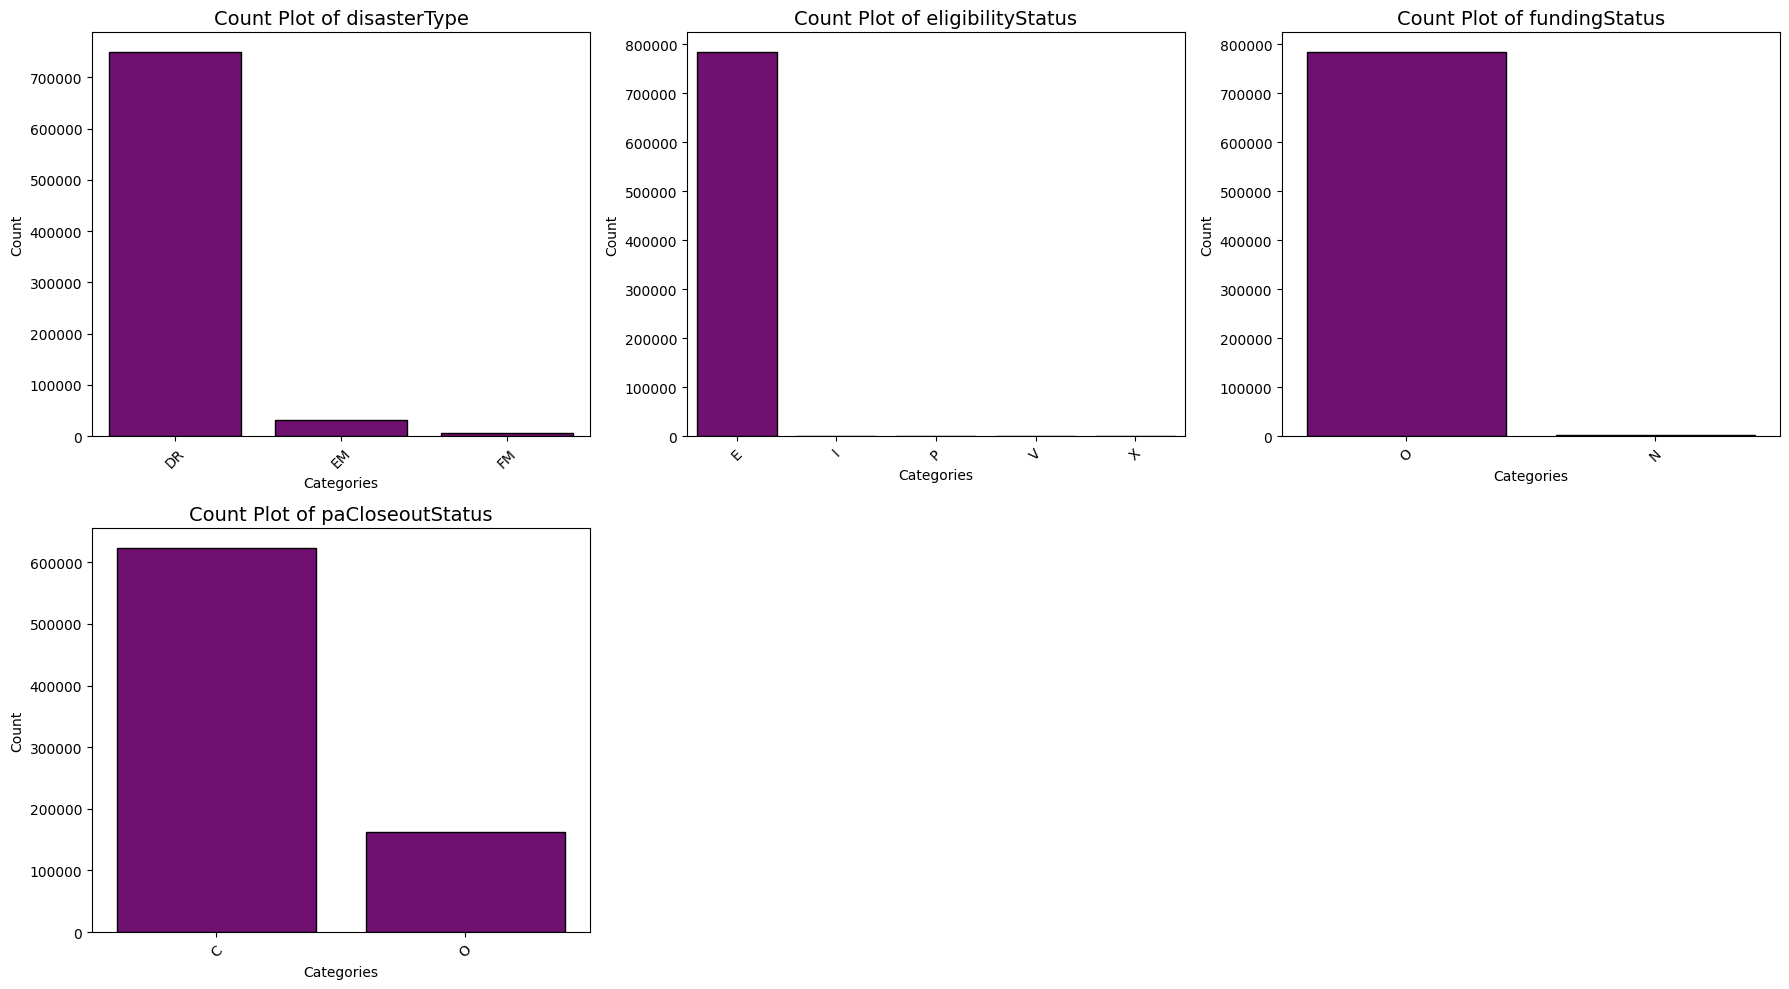

In [131]:
low_cardinal_cols = [
    col for col in cat_cols if df_clean[col].nunique() <= 10
]

n_cols = 3
n_rows = math.ceil(len(low_cardinal_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(low_cardinal_cols):
    sns.countplot(
        data=df_clean,
        x=col,
        ax=axes[idx],
        edgecolor='black',
        color='purple'
    )

    axes[idx].set_title(f"Count Plot of {col}", fontsize=14)
    axes[idx].set_xlabel("Categories")
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(len(low_cardinal_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [132]:
high_cardinal_col = ['damageCategoryCode', 'incidentType', 'state', 'incidentType', 'county']

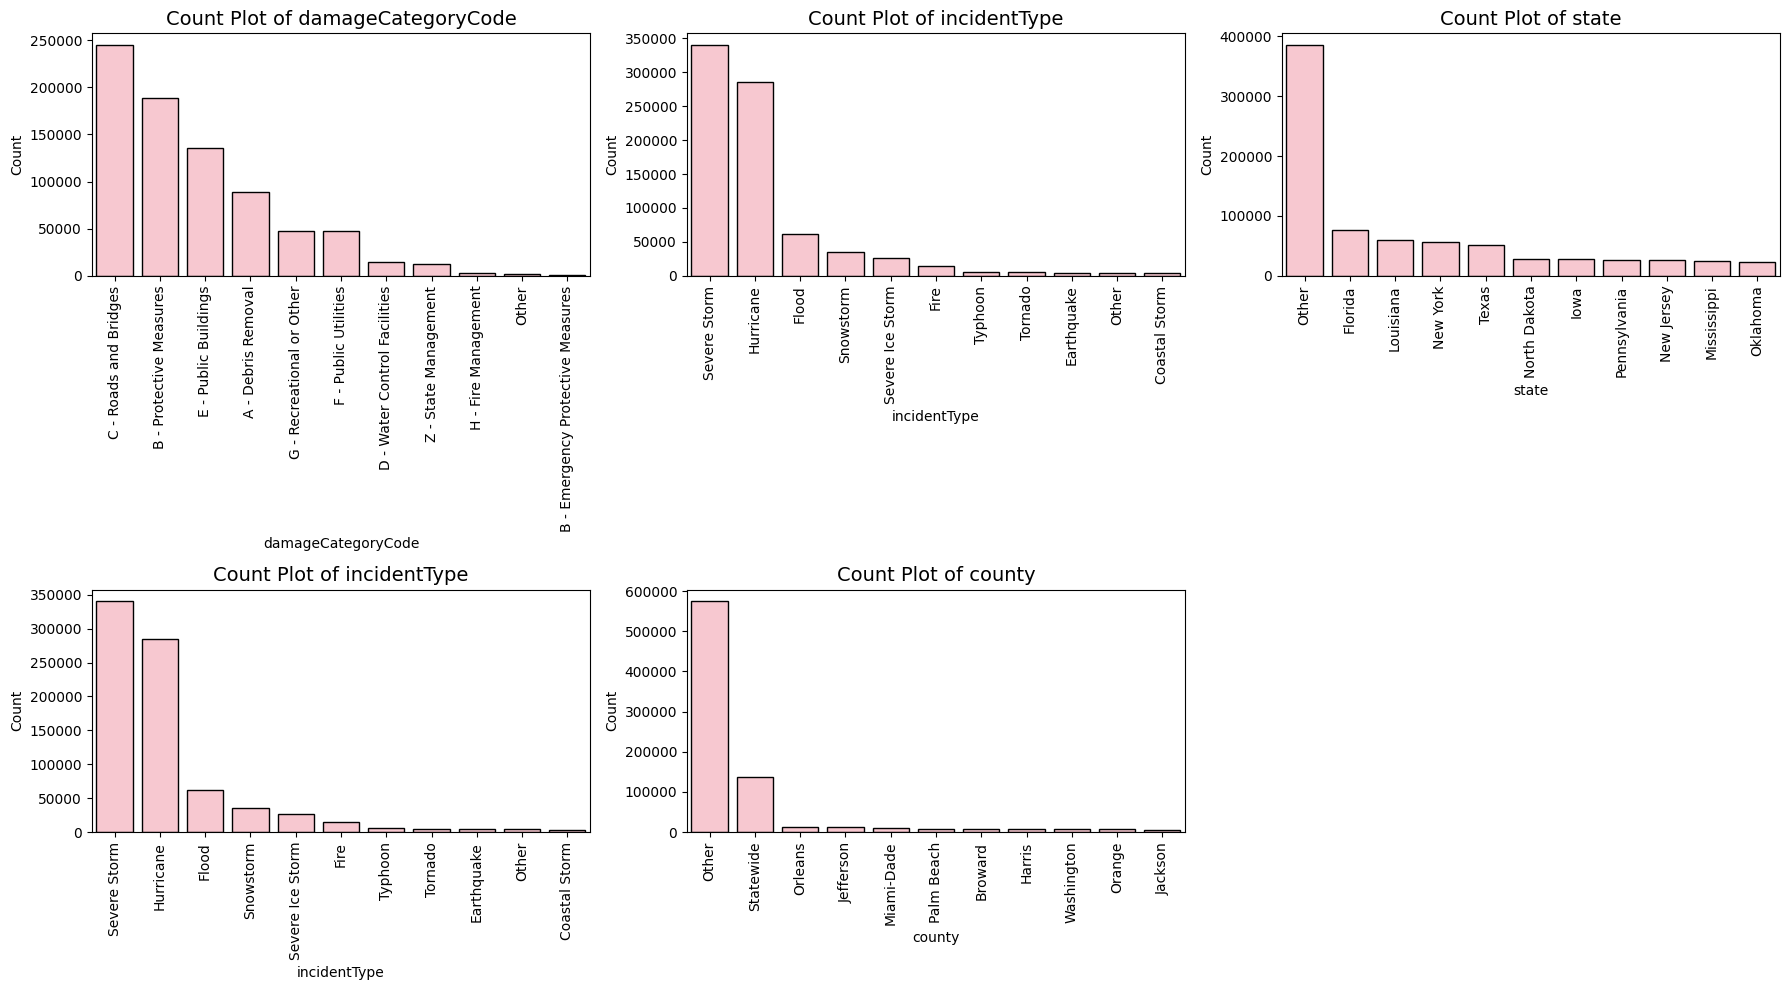

In [133]:
n_cols = 3
n_rows = math.ceil(len(high_cardinal_col) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(high_cardinal_col):

    value_counts = df_clean[col].value_counts(dropna=True)

    top_10 = value_counts.nlargest(10).index

    plot_data = df_clean[col].where(
        df_clean[col].isin(top_10),
        other="Other"
        )
    
    sns.countplot(
        x=plot_data,
        ax=axes[idx],
        order=plot_data.value_counts().index,
        color="pink",
        edgecolor="black"
    )

    axes[idx].set_title(f"Count Plot of {col}", fontsize=14)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis='x', rotation=90)

# Remove unused axes
for j in range(len(high_cardinal_col), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [135]:
df.county.value_counts().nlargest(10)

county
Statewide     174741
Orleans        22993
Jefferson      15873
Miami-Dade     15248
Palm Beach      9751
Harris          9222
Broward         9063
Orange          7868
Harrison        7787
Washington      7657
Name: count, dtype: int64

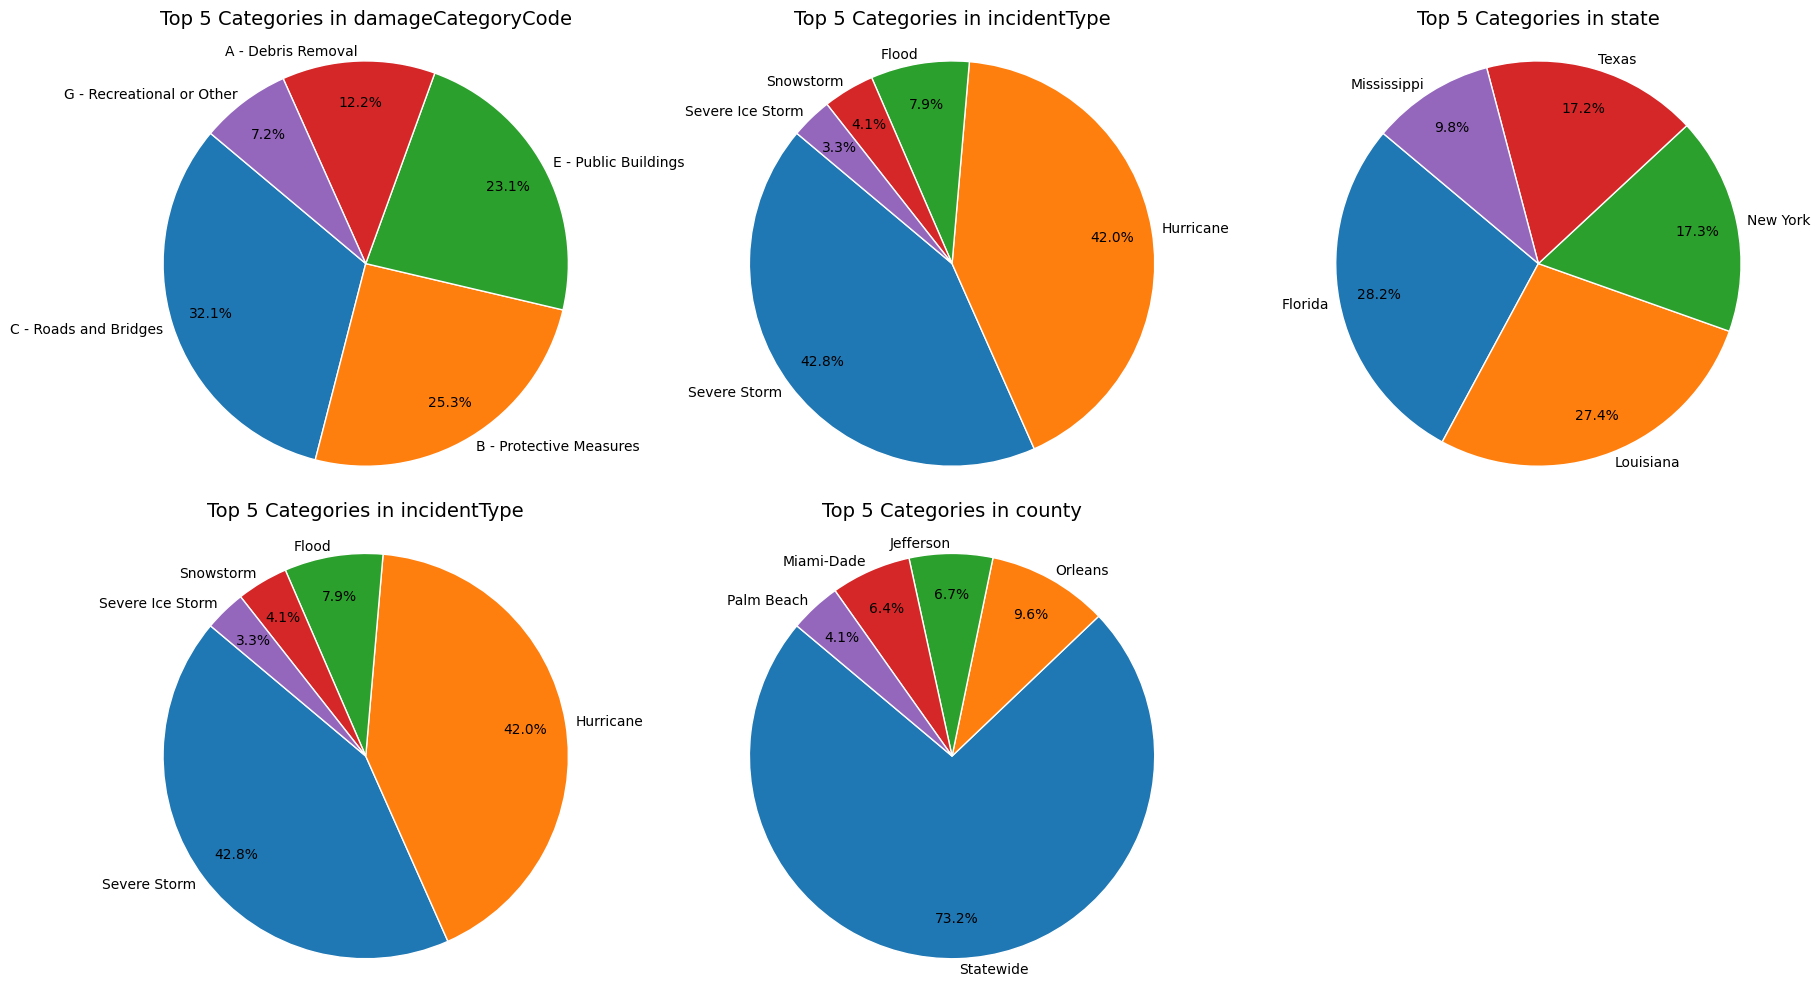

In [136]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(high_cardinal_col):
    val_cnt = df[col].value_counts()

    top_k = 5
    labels = val_cnt.nlargest(top_k).index
    values = val_cnt.nlargest(top_k).values

    axes[idx].pie(
        values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.8,
        labeldistance=1.05,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    axes[idx].set_title(f"Top {top_k} Categories in {col}", fontsize=14, pad=12)
    axes[idx].axis('equal')

# Remove unused axes
for j in range(len(high_cardinal_col), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


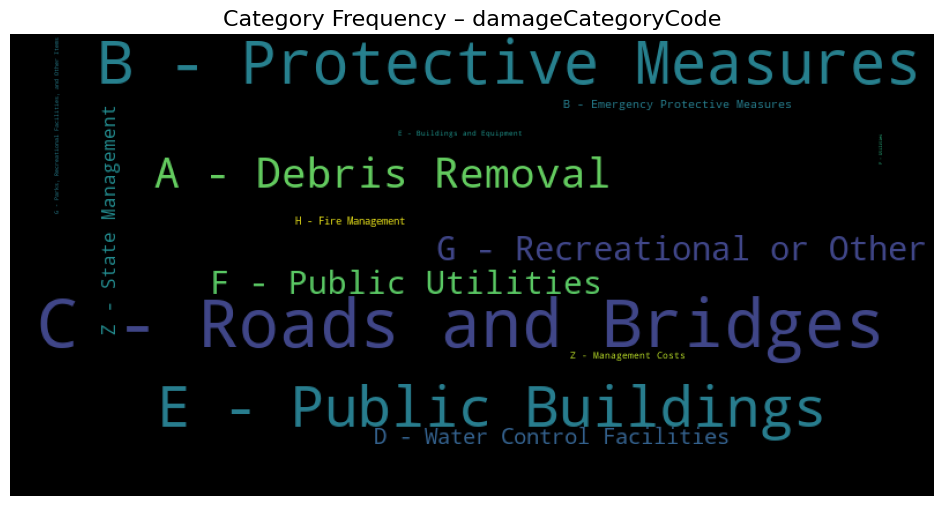

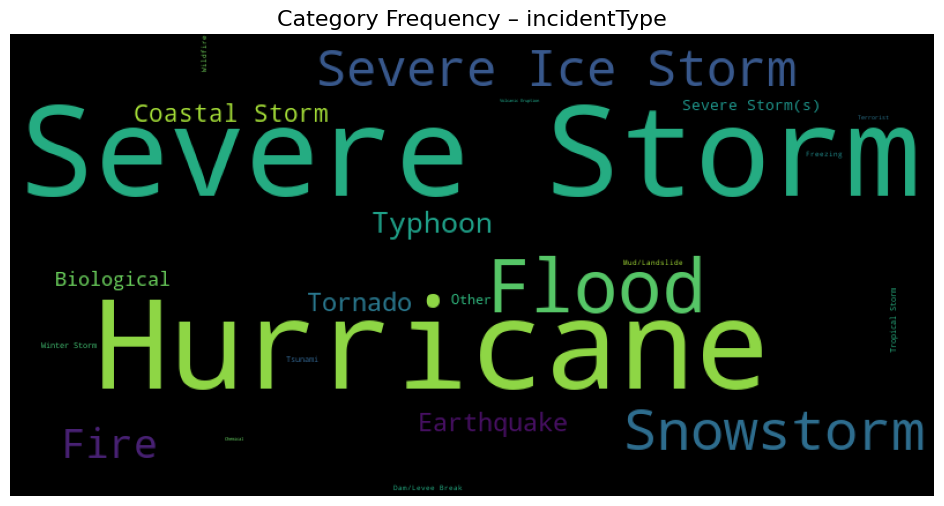

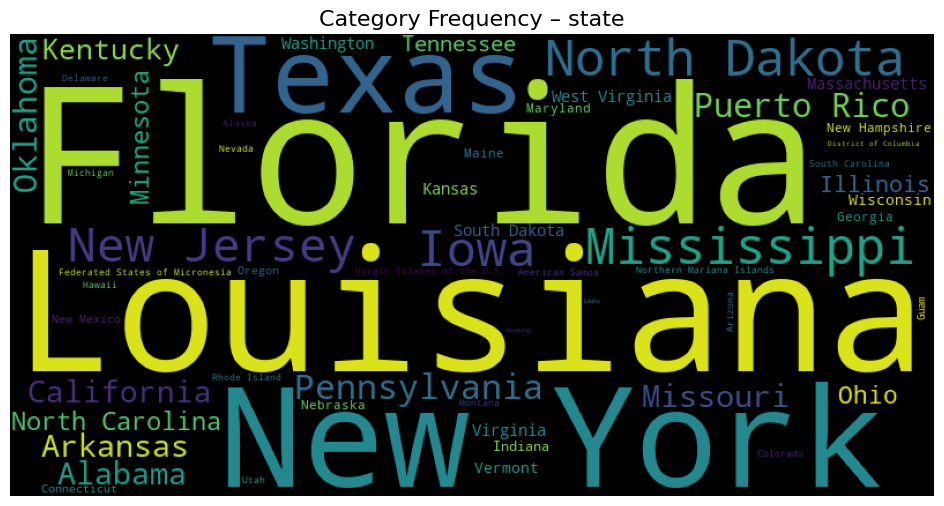

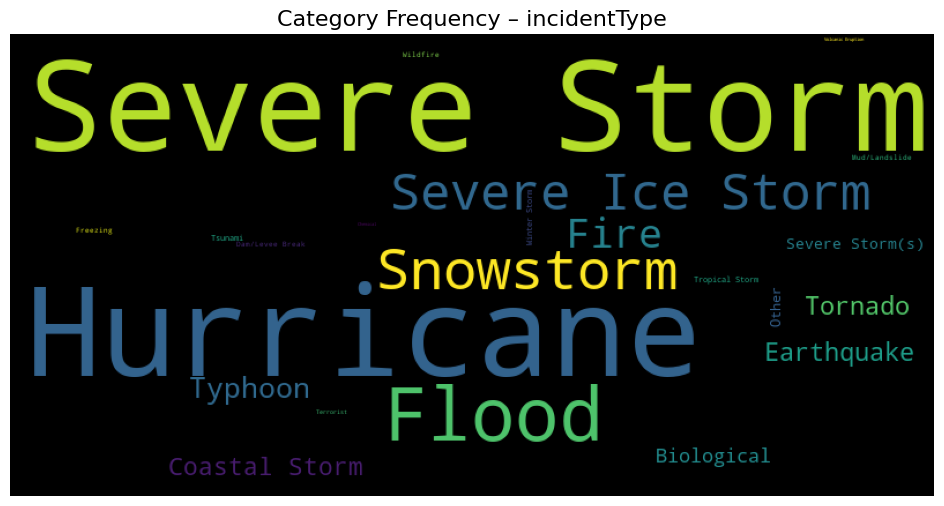

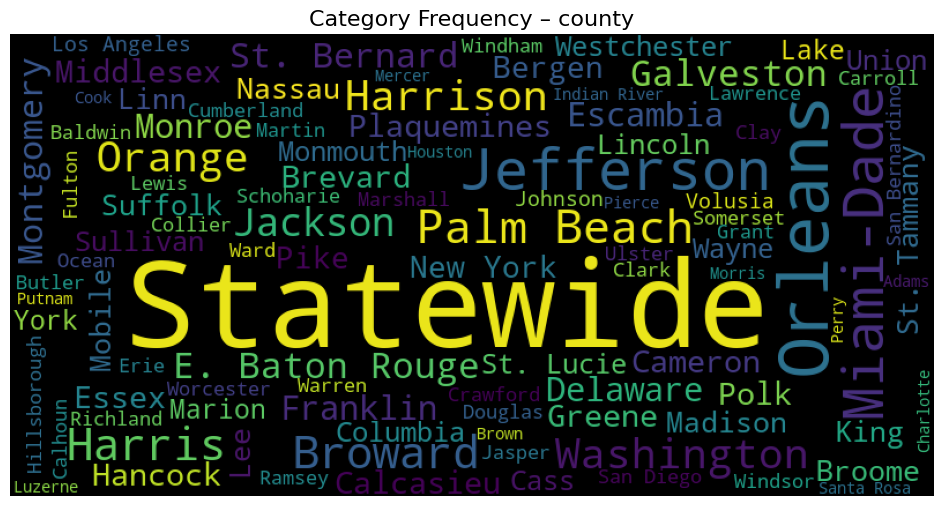

In [139]:
for col in high_cardinal_col:
    freqs = (
        df[col]
        .dropna()
        .astype(str)
        .value_counts()
        .to_dict()
    )

    wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        max_words=100
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f"Category Frequency – {col}", fontsize=16)
    plt.show()

# BI-Variate Analysis

In [138]:
df_clean.head(5)

,region,disasterNumber,sriaDisaster,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,applicantId,applicantName,pnpStatus,damageCategoryCode,federalShareObligated,dateObligated,pwNumber,projectTitle,versionNumber,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,9,1397,0,EARTHQUAKE,DR,Earthquake,2001-12-05,GU,Guam,Statewide,000-U6K9Y-00,GUAM WATERWORKS AUTHORITY,0.0,F - Public Utilities,121.50,2002-02-01,37,PUMP STATION REPAIR - HAIRLINE CRACKS,0.0,E,O,C,756305cd-2657-42ed-bb35-8c8013c551a8
1,4,1381,0,TROPICAL STORM ALLISON,DR,Severe Storm,2001-06-17,FL,Florida,Washington,133-99133-00,WASHINGTON COUNTY,0.0,C - Roads and Bridges,3116.84,2001-10-03,210,ROADS AND BRIDGES,0.0,E,O,C,553d4c29-85ef-4002-ad7f-0b10c0b3da19
2,6,1709,0,"SEVERE STORMS, TORNADOES, AND FLOODING",DR,Severe Storm,2007-06-29,TX,Texas,Henderson,213-99213-00,HENDERSON (COUNTY),0.0,C - Roads and Bridges,7211.69,2007-11-09,2594,ROADS AND BRIDGES,0.0,E,O,C,743771d1-7292-4009-afc7-a8258ebc4414
3,4,1549,0,HURRICANE IVAN,DR,Hurricane,2004-09-15,AL,Alabama,Baldwin,003-57144-00,ORANGE BEACH,0.0,A - Debris Removal,129387.21,2005-01-29,1509,DEBRIS REMOVAL,0.0,E,O,C,4c86e4b3-3e25-4b89-904a-26048d4181c1
4,5,1370,0,"SEVERE WINTER STORMS, FLOODING, AND TORNADOES",DR,Flood,2001-05-16,MN,Minnesota,Houston,055-33866-00,LA CRESCENT,0.0,A - Debris Removal,11512.50,2001-09-22,1418,DEBRIS REMOVAL,0.0,E,O,C,158efd8c-5c67-418b-8951-6e3ca9be537e


Declaration Date

The declarationDate represents the point at which a disaster is officially declared by FEMA, triggering federal involvement. This date is closely tied to the disaster event itself or its immediate aftermath. It marks when a state’s request for assistance is approved and when various forms of federal aid become authorized.

Date Obligated

The dateObligated represents the date on which FEMA formally committed federal funds to a specific Public Assistance project. This occurs after the disaster has been declared and after the project has been reviewed for eligibility, scope, and estimated cost. In many cases, the obligation date can be weeks or even months later than the declaration date.

In [140]:
# Unique Applicants per Declaration Date

df_applicants_ts = (
    df_clean
    .groupby("declarationDate", as_index=False)["applicantId"]
    .nunique()
    .sort_values("declarationDate")
)

fig = px.line(
    df_applicants_ts,
    x="declarationDate",
    y="applicantId",
    title="Unique Applicants per Declaration Date",
    labels={
        "declarationDate": "Declaration Date",
        "applicantId": "Number of Unique Applicants"
    }
)

fig.update_layout(
    width=1000,
    height=400,
    title=dict(font=dict(size=18)),
    xaxis=dict(
        title_font=dict(size=16),
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title_font=dict(size=16),
        tickfont=dict(size=12)
    )
)

fig.update_xaxes(
    tickangle=45,
    rangeslider_visible=True
)

fig.show()